# FlameFrame: A 2D Forest Fire Simulation using Cellular Automata

### Introduction
Forest fires are a complex phenomenon that can be difficult to study in the real world due to their unpredictable nature and the potential risks they pose to researchers. By developing a simulation of a forest fire, I can create a safe and controlled environment to study the behavior of fires and the factors that contribute to their spread. This model concept involves creating a grid of cells that represent the forest, with each cell having a specific state (such as "tree", "burning", or "empty"). I will then use a set of rules to determine how the fire spreads from cell to cell, taking into account factors such as wind direction, material type, and the proximity of other burning trees. This will be traced over randomly generated landscapes to track the amount of landscape burned and the time it took to either stop the fire or burn completely (whichever comes first).


### Motivation
The utility of simulating a forest fire using cellular automata is that it allows us to study the behavior of fires in a safe and controlled environment. Forest fires can be devastating events that cause significant damage to ecosystems and infrastructure, so understanding the factors that contribute to their spread is crucial for developing effective prevention and management strategies. It is useful to test different scenarios with forest fires because they are complex, dynamic systems that are influenced by a multitude of factors. Testing different scenarios can help us understand how these factors interact and contribute to the behavior of fires. By simulating different scenarios, I can investigate the impact of various factors, such as wind speed and direction, terrain, material composition (fuel load), and weather conditions on the spread and behavior of a fire.

In addition, testing different scenarios can also help us evaluate the effectiveness of different management strategies, such as prescribed burning, thinning, and fire suppression. For example, by simulating the impact of prescribed burns on the fuel load of a forest, I can assess how effective this strategy is at reducing the risk of severe wildfires.

Overall, testing different scenarios with forest fires using simulations allows us to explore the behavior of fires in a controlled environment, where I can manipulate different variables and examine their impact. This can lead to a better understanding of forest fire dynamics and help inform decision-making around prevention and management strategies.


### Background
**Physical Laws and Rules:**

The behavior of a forest fire is influenced by various physical laws and rules that govern the spread of fire. These include heat transfer, fuel properties, wind direction and speed, and topography. In this simulation, we will use a set of rules to model the behavior of a forest fire. These rules include:

- Ignition: A tree catches fire when its neighbor is already on fire, and the probability of ignition is influenced by the distance between the two trees.
- Spread: Once a tree is on fire, it can ignite neighboring trees, with the probability of ignition depending on the distance and wind direction.
- Extinguishing: A burning tree can be extinguished if it is surrounded by at least two non-burning trees.

**Parameter Values:**

The values of various parameters in the simulation, such as the probability of ignition or the rate of fire spread, are important to determine the accuracy and validity of the simulation. These values are typically determined through experimentation and calibration against real-world data. The values I am using come from data presented in the following papers:
 - https://www.researchgate.net/figure/Annual-Mean-Windspeed-Standard-Deviation-Operating-Probability-for-v-ci-4-m-s-A1_tbl1_253657631
 - https://www.nature.com/articles/s41598-021-98244-w
 - https://data-usfs.hub.arcgis.com/datasets/d93720867d1a4aa69f4a15dbf3ddeaea/explore (this is the main source for burn probabilities)

**Assumptions:**

Assumptions are necessary for any simulation to simplify the system and make it more manageable. In this forest fire simulation, we make several assumptions to simplify the system and reduce the computational complexity. These assumptions include:

- All trees are of the same species and have the same properties.
- The wind speed and direction are constant throughout the simulation.
- The fuel load is uniform across the forest.
- Once a block is burned, it cannot be reignited
- Ignition points are randomized

These assumptions help us to focus on the key factors that influence the behavior of a forest fire, without introducing unnecessary complexity into the simulation.

**Course Concepts**

- Representations of Space: The output of this simulation is in a graphical format to visually track fires over time
- Simulation Time and Updating: The output file, a gif, will have each frame be a step in the spread of a fire, forming a cohesive sequence of burn graphs to show the progression of a fire over time
- Rules: All blocks operate on the same ruleset driven by the assumptions above.
- Numerical Techniques: The map of the forest fire, the "fire map", incrementally updates per frame of the output gif. Every block is burning/not burning based on its proximity to a burning block multiplied by the block-type probability of burn.


### Verification
The majority of verification is done visually but is supported by references in real-world research and data. The forest fire simulation needs to respect the following qualitative attributes:
- The fire must progress in the direction of wind
- The fire progression increases as the wind speed and/or fuel load increase (more trees)
- Once an area is burned, it cannot reignite and will stay "burnt"
- The fire resembles satellite imagery of forest fire progression (and is in accordance with cellular automata): https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-019-56967-x/MediaObjects/41598_2019_56967_Fig5_HTML.png
- The fire respects different types of terrain (it moves faster through trees and slower through stone)

In regards to the quantitative verification, that can only be controlled by the relative densities of terrain types and wind speed being drawn from research data. I will be using ArcGIS to gather the terrain densities and wind speeds for different scenarios. Quantitative data will also be based off of my own experience with forest fires and their progression. This comes from 7 years in Boy Scouts and having multiple fire safety trainings to draw from. 


### Simulation Scenarios
**For all sims:** 

If a simulation's ignition point is set near the top of the graph, it will be hard to see the effects of a forest fire (because wind is only upward in this sim). Rerun until ignition point(s) is in the middle or bottom of graph to see fire spread.

**Important Vocabulary:** 

*Completeness* = the ratio of green blocks in areas of gray. The less green, the more complete

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
from PIL import Image

class ForestFireSimulation:
    def __init__(self, width, height, tree_prob=0.6, grass_prob=0.3, stone_prob=0.1, filename='forest_fire.gif'):
        self.width = width
        self.height = height
        self.tree_prob = tree_prob
        self.grass_prob = grass_prob
        self.stone_prob = stone_prob
        self.wind_speed = 0
        self.terrain = np.zeros((width, height))
        self.fire_map = np.zeros((width, height))
        self.filename = filename
        self.reset()

    def reset(self):
        self.wind_speed = np.random.normal(5, 2)
        self.terrain = np.random.choice([0, 1, 2], size=(self.width, self.height), p=[self.tree_prob, self.grass_prob, self.stone_prob])
        self.fire_map = np.zeros((self.width, self.height))

    def set_ignition_points(self, num_points):
        x_coords = np.random.randint(self.width, size=num_points)
        y_coords = np.random.randint(self.height, size=num_points)
        for x, y in zip(x_coords, y_coords):
            self.fire_map[x, y] = 1

    def ignite_neighbors(self, x, y):
        neighbors = []
        for i in range(max(0, x-1), min(x+2, self.width)):
            for j in range(max(0, y-1), min(y+2, self.height)):
                if self.fire_map[i, j] == 0 and \
                        (self.terrain[i, j] == 0 or self.terrain[i, j] == 1):
                    ignition_prob = 0.5 / ((x - i)**2 + (y - j)**2 + 1) ** 0.5
                    if self.terrain[i, j] == 0: # tree
                        ignition_prob *= 1.5
                    elif self.terrain[i, j] == 1: # grass
                        ignition_prob *= 0.8
                    if np.random.uniform() < ignition_prob:
                        neighbors.append((i, j))
        for neighbor in neighbors:
            self.fire_map[neighbor[0], neighbor[1]] = 1

    def spread_fire(self):
        new_fire_map = np.zeros((self.width, self.height))
        for i in range(self.width):
            for j in range(self.height):
                if self.fire_map[i, j] == 1:
                    if np.random.uniform() < 0.3:
                        new_fire_map[i, j] = 2  # burned
                    else:
                        new_fire_map[i, j] = 1  # burning
                    self.ignite_neighbors(i, j)
                elif self.fire_map[i, j] == 2:
                    new_fire_map[i, j] = 2  # already burnt
                else:
                    new_fire_map[i, j] = self.fire_map[i, j]  # non-flammable terrain
        self.fire_map = new_fire_map

    def animate(self, i):
        plt.clf()
        im = plt.pcolor(self.fire_map, cmap=self.cmap, norm=self.norm, edgecolors='k', linewidths=0.5)
        plt.title(f'Forest Fire Simulation - Step {i}')
        self.spread_fire()
        return im

    
    def simulate(self, num_steps):
        fig = plt.figure(figsize=(8, 6))
        self.cmap = colors.ListedColormap(['green', 'orange', 'gray', 'red'])
        bounds = [0, 1, 2, 3, 4]
        self.norm = colors.BoundaryNorm(bounds, self.cmap.N)
        ani = FuncAnimation(fig, self.animate, frames=num_steps, interval=500, repeat=False)
        ani.save(self.filename, writer='imagemagick')


### Simulation 1: Standard Forest (Majority Trees, Single Ignition)
Standard Forests are 60% trees, 30% grass, and 10% stone. This is the only instance that will start with a single ignition point. The real-world equivalent is a campfire (or gender reveal) gone wrong. 

**Results:** Forests burn pretty quickly and it can have a widespread impact, even with a single ignition point. This and the next simulation will act as a baseline to compare other terrain types.

MovieWriter imagemagick unavailable; using Pillow instead.


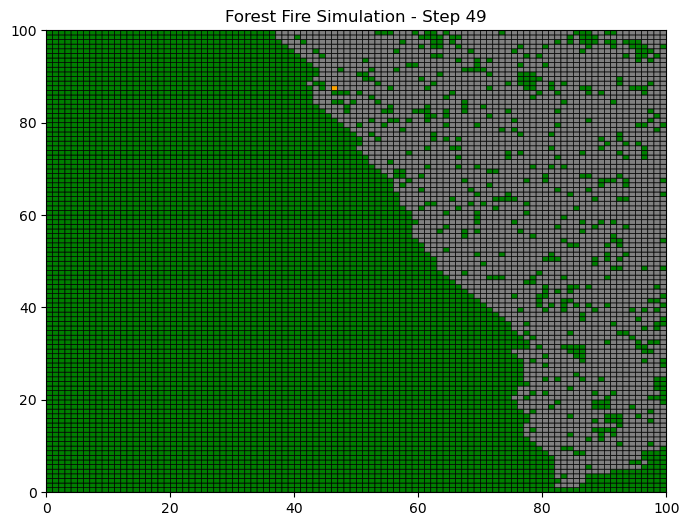

In [88]:
fire_sim_std_forest = ForestFireSimulation(100, 100, tree_prob=0.6, grass_prob=0.3, stone_prob=0.1,
                                           filename='std_forest_fire.gif')
fire_sim_std_forest.set_ignition_points(1)
fire_sim_std_forest.simulate(50)

### Simulation 2: Standard Forest (Multiple Ignition)
Same as above, but with 3 ignition points

**Results:** This burn will act as a baseline in both the speed of the burn and the amount of the forest burned (less the latter because of randomized ignition points)

MovieWriter imagemagick unavailable; using Pillow instead.


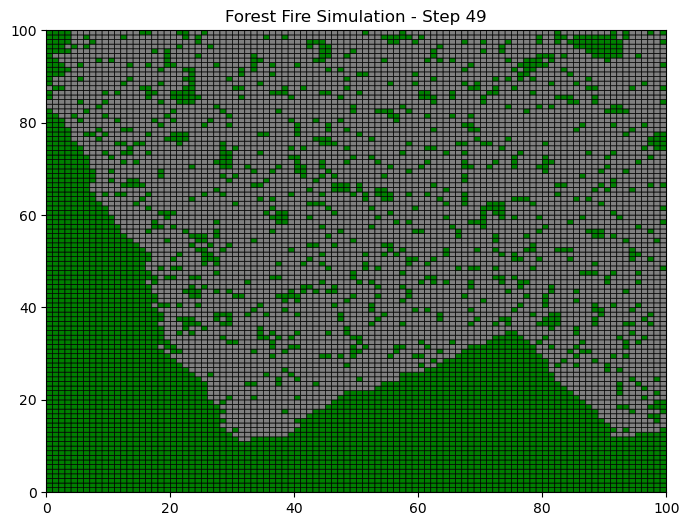

In [83]:
fire_sim_std_forest_mult = ForestFireSimulation(100, 100, tree_prob=0.6, grass_prob=0.3, stone_prob=0.1,
                                           filename='std_forest_fire_multignite.gif')
fire_sim_std_forest_mult.set_ignition_points(3)
fire_sim_std_forest_mult.simulate(50)

### Simulation 3: Dense Forest (California)
Dense forests are 95% trees and 5% grassland. Little to no stone spaces.

**Results:** Dense forests burn much quicker than standard forests due to the increase fuel load per area. This simulation had the highest speed of burn and the most complete burn out of all other sims.

MovieWriter imagemagick unavailable; using Pillow instead.


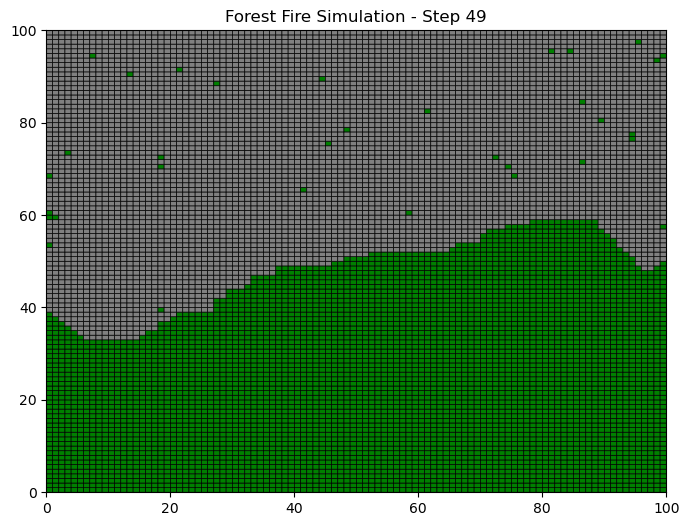

In [94]:
fire_sim_dense_forest = ForestFireSimulation(100, 100, tree_prob=0.95, grass_prob=0.05, stone_prob=0.0, 
                                             filename='dense_forest_fire.gif')
fire_sim_dense_forest.set_ignition_points(3)
fire_sim_dense_forest.simulate(50)

### Simulation 4: Central Forest-Grassland Transition (Illinois)
In a forest to grassland transition, there is only about 15% of land covered by trees. Majority is grass (80%) with some stone spaces (5%)

**Results:** The transition terrain burned similarily to the standard forest. There are only some minute differences in speed between the two with the transition terrain being slower. Also, the transition terrain is less complete than the standard forest.

MovieWriter imagemagick unavailable; using Pillow instead.


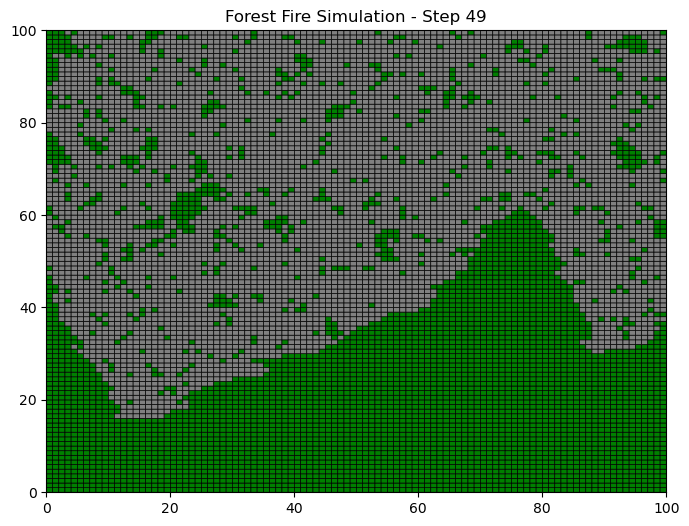

In [85]:
fire_sim_forest_grassland = ForestFireSimulation(100, 100, tree_prob=0.15, grass_prob=0.8, stone_prob=0.05, 
                                             filename='forest_grassland_fire.gif')
fire_sim_forest_grassland.set_ignition_points(3)
fire_sim_forest_grassland.simulate(50)

### Simulation 5: Prarie (Kansas)
Praries are almost all grass (92.5%). Little stone spaces and even less tree coverage.

**Results:** This burn is noticably different than the standard forest. Prarie fires burn a lot slower and are less complete than standard forest burns. This would give responders time to put out the fire and it seems to be the most manageable terrain in regards of active prevention (Active meaning it would require external influence, humans, to put out the fire)

MovieWriter imagemagick unavailable; using Pillow instead.


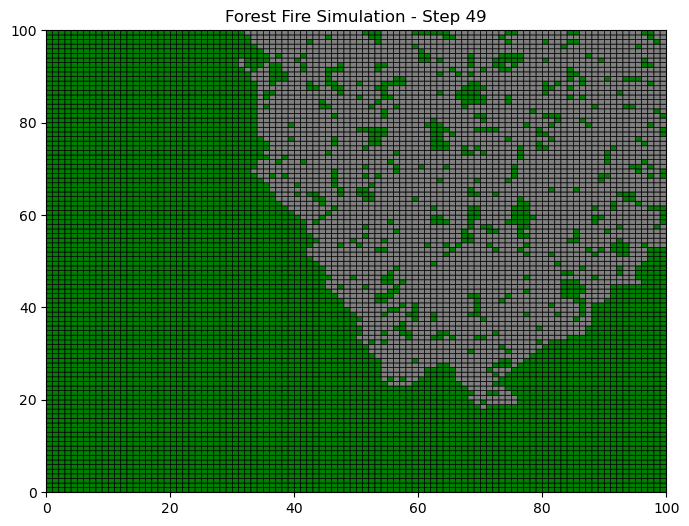

In [86]:
fire_sim_prarie = ForestFireSimulation(100, 100, tree_prob=0.025, grass_prob=0.925, stone_prob=0.05, 
                                             filename='prarie_fire.gif')
fire_sim_prarie.set_ignition_points(3)
fire_sim_prarie.simulate(50)

### Simulation 6: Savannah (Arizona)
Savannahs are the most sparse biome with less than 1% tree coverage. Majority coverage is by dirt/sand/stone space (around 60%).

**Results:** Widespread Savannah fires rarely happen in real life, and this simulation reflects that fact. There is no need for active prevention in savannah fires because of the low fuel load per area.

MovieWriter imagemagick unavailable; using Pillow instead.


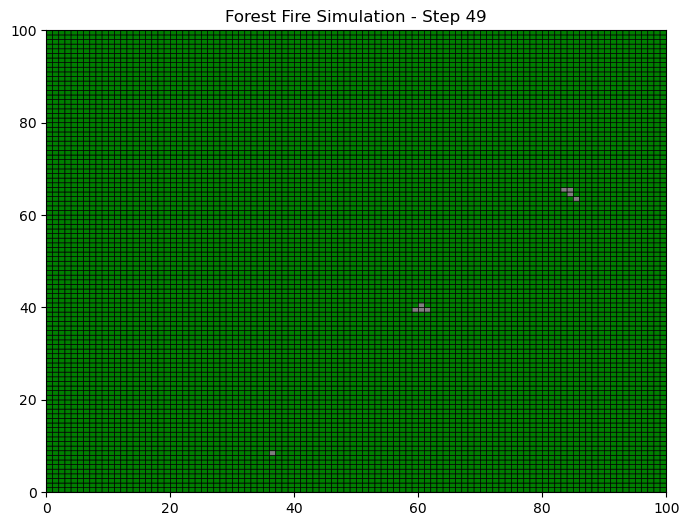

In [87]:
fire_sim_savannah = ForestFireSimulation(100, 100, tree_prob=0.01, grass_prob=0.4, stone_prob=0.59, 
                                             filename='savannah_fire.gif')
fire_sim_savannah.set_ignition_points(3)
fire_sim_savannah.simulate(50)

### Simulation 8: A Forest Fire Playground For You!
Feel free to change these values to make your own forest fire!:
- **tree_prob, grass_prob, and stone_prob**: Controls the terrain composition. Values must sum to 1
- **set_ignition_points**: Vary the number of random ignition points. More points, More flame!
- **simulate(int)**: To increase the number of frames in the final gif output, change this number

In [ ]:
your_fire_sim = ForestFireSimulation(100, 100, tree_prob=0.33, grass_prob=0.33, stone_prob=0.34, 
                                             filename='your_forest_fire.gif')
your_fire_sim.set_ignition_points(3)
your_fire_sim.simulate(50)

### Evaluation
**Overall Results** 

This simulation demonstrated the ability to see the progression of a fire in multiple terrain settings with varying fuel loads, wind speeds, and ignition points. There are, however, important limitations to note. This simulation does not address the following factors that influence a forest fire:
- Varying Wind Speed and Direction: Changes in speed and direction with wind can drastically change the spread of a fire. This simulation only models one direction with a randomly chosen, constant speed
- Levels of UV exposure: Most forest fires happen because of overexposure from the sun. This model does not account for any level of sunlight influence
- Precipitation: Rainfall is a natural preventor of forest fires, as rain can put out fires relatively easily. This model does not account for precipitation of any form
- Temperature: The ambient temperature can affect the probabilities of ignition and firespread. The colder an enviroment is, the less likely ignition or firespread is to occur. This model assumes a constant temperature. Other weather conditions, such as humidity, are also constant in this model.
- Wildlife: Some wildlife species, such as birds that carry burning sticks, can accidentally start fires. Additionally, the presence of certain animal populations can impact fuel levels and patterns. This model does not account for any wildlife.
- Complex Fuel Loads: The amount, type, and arrangement of fuel (such as trees, shrubs, grass, and dead leaves) can influence the intensity and spread of a forest fire. This model only accounted for three very-simplified types of fuel load (tree, grass, stone) and assumed a uniform distribution. This approaches real-world conditions, but does not get near the complexity of actual scenarios
- Topography: The shape and slope of the land can affect the direction and speed of a fire, and can also impact firefighting efforts. This model is assumed flat and doesn't account for hills, valleys, rivers, etc
- Active Suppression Efforts: The effectiveness of firefighting resources, including water sources, equipment, and personnel, can impact the ability to contain and extinguish a forest fire. This model did not account for any form of non-natural suppression.

**Use Cases for this Simulation**

Given the limitations listed above, this simulation does have benefits. The goal of this forest fire simulation is to give users a general fire spread "instinct". By viewing the results of each scenario, a user should be able to gather an inference for which types of terrain are prone to forest fires, which are not, and how quickly/slowly burns in those terrains progress. This ability to inference, this "instinct", is surprisingly absent from average people who have not experienced fires at scale. Therefore, this simulation is a good educational tool for gaining insight and building an instinct for the behaviour of forest fires.

**Challenges**

The most difficult part of getting this simulation to work was visualizing the progression of the fire. I spent a significant amount of time trying and failing to implement an update method (spread_fire()) that could mesh with the Matplotlib animation library. Initially, I could only get a single output, the end frame, to appear when the program finished. I knew I had to get this to a point of animation, as that is required to show the speed and spread of the fire over time. After advice help from friends (thank you Caleb Troyer and Cam Henning for hearing my rants) I figured it out. By encapsulating the spread_fire() method as its own member function and making a separate animate() member function, I got the simulation to output a gif.

Obtaining real-world data for comparison was another challenge. I spent a lot of time reading through papers trying to find terrain composition percentages (and attempting to simplify very complex compositions). Thankfully, my girlfriend Amanda Lee is an Environmental Engineer who recommended I look up GIS. There is a free resource I used, ArcGIS, to get all the terrain data I needed to input proper composition percentages. Without Amanda's recommendation, this sim would not have been nearly as cool or accurate.

**Other Ways To Simulate**

In reference to this course, I think forest fires could only be simulated in models analogous to cellular automata. Most notably, these are Agent-Based Models, Discrete Event Sims, and Lattice models (like the crystal lattice sim). There are various simulation models available for forest fire simulation that are based off all these models, such as FARSITE, FlamMap, and WFDS.


### Future Work
This forest fire simulation provides benefits as an educational tool to help users gain an "instinct" for the behavior of forest fires. By viewing the results of different scenarios, users can learn which types of terrain are more prone to fires, how quickly they can spread, and how different factors like weather conditions and topography can impact fire behavior. This type of understanding is valuable for people who have not experienced forest fires first-hand and can help improve awareness and preparedness in fire-prone areas.

If there were more time and I had access to more resources, I would like to implement all the limitations listed above. This wouldn't solely be through cellular automata, however. I think if there was a generative ML model that was trained off of swaths of ArcGIS data, it could accurately depict the spread of a fire over 1-1 terrain compositions. Rather than an educational tool, people living in fire-prone areas could use this for contingency planning and prevention. 